In [ ]:
# !pip install topicnet
# !pip install bigartm
# !pip install pymorphy2

In [2]:
# BigARTM, необходим для работы TopicNet
import artm

# Визуализация, работа с данными
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Установка графиков по умолчанию
sns.set(style="darkgrid", palette="Set2")

from topicnet.dataset_manager import api

# topicnet imports
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.models import BaseScore
from topicnet.cooking_machine.models.base_regularizer import BaseRegularizer
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.model_constructor import add_standard_scores
from topicnet.cooking_machine.model_constructor import init_simple_default_model
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from topicnet.viewers.top_tokens_viewer import TopTokensViewer

from IPython.display import display, display_html

# for preprocessing
import nltk

from nltk.collocations import (
    BigramAssocMeasures,
    BigramCollocationFinder,
)
from nltk.corpus import (
    stopwords,
    wordnet,
)

nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger_ru")
nltk.download("stopwords")

from nltk.stem import WordNetLemmatizer

from pymorphy2 import MorphAnalyzer

from collections import Counter

# Для отображения процесса
from tqdm import tqdm

from topicnet.cooking_machine.model_constructor import (
    create_default_topics,
    count_vocab_size,
    init_model,
)

from topicnet.cooking_machine.rel_toolbox_lite import (
    count_vocab_size,
    modality_weight_rel2abs,
)

from typing import Dict, List

from copy import deepcopy

# Возможно использование для подсчёта времени
from time import process_time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/decorators.py:69: DeprecationWarning:

`formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly



[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Вычислительный эксперимент проводится на [коллекции новостей](https://disk.yandex.ru/d/DAdhmVB2eFkdBQ), опубликованных на сайте [Lenta.ru](https://lenta.ru/) в период с мая по август 2008-го года. Загрузим данные.

In [3]:
# С учётом особенности хранения данных в Kaggle
# %cp /kaggle/input/lenta-mid-2008/lenta_2008_may_aug_preprocessed.csv .
lenta_data = Dataset("/kaggle/working/lenta_2008_may_aug_preprocessed.csv")

/opt/conda/lib/python3.10/site-packages/topicnet/cooking_machine/dataset.py:338: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.





Реализуем функцию, которая отвечает за инициализацию тематической модели с заданным параметром `seed`, отвечающим за случайность.

In [4]:
def init_simple_default_model_with_seed(
    dataset: Dataset,
    modalities_to_use: List[str] or Dict[str, float],
    main_modality: str,
    specific_topics: List[str] or int,
    background_topics: List[str] or int,
    seed: int = -1,
) -> artm.ARTM:
    """
    Инициализация стандартной модели BigARTM с учётом случайности.
    Возвращает тематическую модель формата artm.ARTM
    param dataset: данные в формате Dataset
    param modalities_to_use: используемые модальности
    param main_modality: основная модальность
    param specific_topics: предметные темы
    param background_topics: фоновые темы
    param seed: параметр, отвечающий за случайность
    """

    # инициализация весов
    if isinstance(modalities_to_use, dict):
        modalities_weights = modalities_to_use
    else:
        modalities_weights = {class_id: 1 for class_id in modalities_to_use}

    # создание имён тем
    specific_topic_names, background_topic_names = create_default_topics(
        specific_topics, background_topics
    )
    dictionary = dataset.get_dictionary()

    # получение данных о токенах
    tokens_data = count_vocab_size(dictionary, modalities_to_use)
    abs_weights = modality_weight_rel2abs(
        tokens_data, modalities_weights, main_modality
    )

    # инициализация модели
    model = init_model(
        topic_names=specific_topic_names + background_topic_names,
        class_ids=abs_weights,
    )

    # добавление регуляризаторов для фоновых тем
    if len(background_topic_names) > 0:
        model.regularizers.add(
            artm.SmoothSparsePhiRegularizer(
                name="smooth_phi_bcg",
                topic_names=background_topic_names,
                tau=0.0,
                class_ids=[main_modality],
            ),
        )
        model.regularizers.add(
            artm.SmoothSparseThetaRegularizer(
                name="smooth_theta_bcg",
                topic_names=background_topic_names,
                tau=0.0,
            ),
        )

    # задаём зерно случайности
    model.seed = seed
    model.initialize(dictionary)
    add_standard_scores(
        model, main_modality=main_modality, all_modalities=modalities_to_use
    )

    return model

Изначально предусматривалось два варианта.

1. - Обучить базовую модель $M_0$ на $n$ итераций
   - Получить пользовательскую разметку, на основе которой каждая из тем относится либо к $T_+$, либо к $T_0$, либо к $T_-$
   - Создать модель $M_1$ клонированием модели $M_0$, определить пользовательские регуляризаторы, дообучить $M_1$ ещё на $n$ итераций, изменив при этом значение параметра `seed`
   - В дальнейших итерациях поступаем аналогично
 
2. - Обучить базовую модель $M_0$ на $n$ итераций с нуля
   - Получить пользовательскую разметку, на основе которой каждая из тем относится либо к $T_+$, либо к $T_0$, либо к $T_-$
   - Создать модель $M_1$ **с нуля**, обучить $M_1$ на $n$ итераций с использованием другого значения параметра `seed`
   - В дальнейших итерациях поступаем аналогично

Как выяснилось в ходе выполнения эксперимента, в случае применения пользовательских регуляризаторов, применяемых на уровне TopicNet, первый вариант приводит к ошибке и внезапному перезапуску ядра при попытке создать модель $M_2$ путём клонирования $M_1$. Поэтому приходится использовать другой вариант, который обладает преимуществом в плане вариативности распределения тем. Однако исчезает возможность увидеть, как именно улучшается тематическая модель, с точки зрения внутренних критериев.

В качестве значения $|T|$ выбираем $50$, чтобы и способствовать более чёткому разделению по темам, и избежать слишком малого размера тем.

In [5]:
TOTAL_TOPICS = 50  # количество тем

# задаём модель M_0
model_0 = init_simple_default_model_with_seed(
    dataset=lenta_data,
    modalities_to_use={"@lemmatized": 1.0, "@bigram": 0.8},
    main_modality="@lemmatized",
    specific_topics=TOTAL_TOPICS,
    background_topics=1,
    seed=21,
)

# приводим в формат TopicNet
tm_0 = TopicModel(model_0)

Обучаем модель $M_0$ на $50$ итераций. Пользовательские регуляризаторы не используются.

In [6]:
ITER_NUM = 50  # количество итераций

for _ in tqdm(range(ITER_NUM)):
    tm_0._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 50/50 [03:03<00:00,  3.67s/it]


Выведем список тем. Каждая тема характеризуется пятью наиболее вероятными биграммами и пятью наиболее вероятными словами в начальной форме.

In [7]:
model_0_top_tok = TopTokensViewer(tm_0, num_top_tokens=5, method="phi")
model_0_top_tok.view_from_jupyter()

/opt/conda/lib/python3.10/site-packages/topicnet/cooking_machine/pretty_output.py:287: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 джордж_буш 
 0.092020 
 
 
 черноморский_флот 
 0.065130 
 
 
 член_экипаж 
 0.049520 
 
 
 чёрный_море 
 0.027280 
 
 
 министерство_юстиция 
 0.026150 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 самолёт 
 0.023560 
 
 
 буш 
 0.012280 
 
 
 борт 
 0.011620 
 
 
 корабль 
 0.011480 
 
 
 который 
 0.010030 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 населить_пункт 
 0.076510 
 
 
 юго_восток 
 0.041540 
 
 
 углекислый_газ 
 0.029400 
 
 
 чрезвычайный_ситуация 
 0.028120 
 
 
 чрезвычайный_положение 
 0.027750 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 человек 
 0.011360 
 
 
 сообщать 
 0.010000 
 
 
 пожар 
 0.009440 
 
 
 район 
 0.009320 
 
 
 пострадать 
 0.009080 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 социальный_сеть 
 0.076290 
 
 
 набрать_очко 
 0.050440 
 
 
 го_тур 
 0.034250 
 
 
 плей_офф 
 0.031710 
 
 
 кубок_стэнли 
 0.023240 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 матч 
 0.023660 
 
 
 счёт 
 0.022250 
 
 
 очко 
 0.015660 
 
 
 минута 
 0.014220 
 
 
 команда 
 0.010790 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 пресс_релиз 
 0.172520 
 
 
 исполнять_обязанность 
 0.037800 
 
 
 чистый_прибыль 
 0.034640 
 
 
 контрольный_пакет 
 0.027480 
 
 
 русский_язык 
 0.026470 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.047770 
 
 
 год 
 0.023930 
 
 
 акция 
 0.020650 
 
 
 процент 
 0.019000 
 
 
 миллиард 
 0.017370 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 принимать_участие 
 0.142040 
 
 
 пропасть_вести 
 0.057110 
 
 
 ближний_восток 
 0.034270 
 
 
 стихийный_бедствие 
 0.030100 
 
 
 глобальный_потепление 
 0.023060 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 человек 
 0.015020 
 
 
 принимать 
 0.011680 
 
 
 год 
 0.010850 
 
 
 который 
 0.010010 
 
 
 тысяча 
 0.009690 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 речь_идти 
 0.130050 
 
 
 норильский_никель 
 0.035240 
 
 
 владимир_потанин 
 0.028610 
 
 
 михаил_прохоров 
 0.028610 
 
 
 ставропольский_край 
 0.024150 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 речь 
 0.014900 
 
 
 который 
 0.013410 
 
 
 идти 
 0.012150 
 
 
 год 
 0.009760 
 
 
 это 
 0.008060 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 предъявить_обвинение 
 0.084760 
 
 
 лишение_свобода 
 0.064420 
 
 
 признать_виновный 
 0.058260 
 
 
 арбитражный_суд 
 0.040690 
 
 
 тюремный_заключение 
 0.028530 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.050350 
 
 
 год 
 0.031210 
 
 
 иск 
 0.012640 
 
 
 дело 
 0.012590 
 
 
 обвинение 
 0.011510 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 тнк_вр 
 0.114360 
 
 
 тнк_bp 
 0.047770 
 
 
 роберт_дадли 
 0.029980 
 
 
 альфа_группа 
 0.023570 
 
 
 ролан_гарроса 
 0.019230 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 тнк 
 0.019720 
 
 
 вр 
 0.016830 
 
 
 компания 
 0.011840 
 
 
 bp 
 0.010490 
 
 
 который 
 0.010460 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 иа_regnum 
 0.028270 
 
 
 british_airways 
 0.022190 
 
 
 строгий_режим 
 0.020630 
 
 
 колония_строгий 
 0.018690 
 
 
 вред_здоровье 
 0.017110 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.012720 
 
 
 который 
 0.009840 
 
 
 заключить 
 0.008850 
 
 
 колония 
 0.008450 
 
 
 сообщать 
 0.006950 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 apple_iphone 
 0.019520 
 
 
 вячеслав_быков 
 0.019520 
 
 
 федерация_хоккей 
 0.016130 
 
 
 

Релевантные: 12, 21, 29, 30, 35
Нерелевантные: 31

Релевантные темы:
   - $12$ (Дмитрий Медведев и его международные контакты)
   - $21$ (события на Кавказе в августе 2008 года)
   - $29$ (Украина, политика и ситуация по переговорам по газовой сделке)
   - $30$ (президентские выборы в США, 2008)
   - $35$ (Путин в качестве премьер-министра)

Нерелевантные темы:
   - $31$ (конфликт на Кавказе в августе 2008 года и международная реакция)

Остальные темы являются «мусорными».

Далее представляем регуляризаторы.

1. Регуляризатор фиксации тем. Предполагается его использование в целях сохранения ранее найденных релевантных тем. Так как часть документов может быть отнесена к нерелевантной теме, которая по большей части дублирует одну из релевантных, но при этом можеть быть не отнесена к соответствующей релевантной теме, то имеет смысл зафиксировать и темы, которые относятся к $T_0$. Для этих целей используется регуляризатор сглаживания, общий вид формулы которой $$R (\Phi, \Theta) = \beta_0 \sum \limits_{t \in T_0} \sum \limits_{w \in W} \beta_{wt} \ln \varphi_{wt} + \alpha_0 \sum \limits_{d \in D_0} \sum \limits_{t \in T} \alpha_{td} \ln \theta_{td}$$
   Коэффициент $\tau$, соответствующий этому регуляризатору, должен быть достаточно большим, чтобы предовратить обучение модели на столбцах матрицы $\Phi$, которые соответствуют релевантным темам и связанным с ними нерелевантными темами во избежание увеличения мусорных тем за счёт нерелевантных.
   
2. Регуляризатор декоррелирования. Предназначен для отделения «мусорных» тем и релевантных тем с целью обнаружения новых тем, подходящих под исследование пользователя. Далее введём дополнительные обозначения:
   - $\widetilde{\Phi}$ — матрица $\Phi$ для предыдущей модели
   - $T_-$ — «мусорные» темы
   - $T_+$ — релевантные темы
   Далее выпишем формулу регуляризатора, а также M-шага алгоритма.
   $$
   R(\Phi) = -\tau \sum \limits_{t \in T_+} \sum \limits_{s \in T_-} \sum \limits_{w \in W} \varphi_{wt} \widetilde{\varphi}_{ws} \to \max \\
   R(\Phi) = -\tau \sum \limits_{t \in T_+ \\ s \in T_-} \left\langle \varphi_t, \widetilde{\varphi}_s \right\rangle \to \max \\
   R(\Phi) = -\tau \sum \limits_{t \in T_+} \left\langle \varphi_t, \sum \limits_{s \in T_-} \widetilde{\varphi}_s \right\rangle \to \max \\
   \frac{\partial R}{\partial \varphi_{wt}} = -\tau [t \in T_+] \sum \limits_{s \in T_-} \widetilde{\varphi}_{ws} \\
   \varphi_{wt} = \text{norm}_{w \in W} \left(n_{wt} - \tau \varphi_{wt} [t \in T_+] \sum \limits_{s \in T_-} \widetilde{\varphi}_{ws}\right)
   $$
   Реализовать регуляризатор возможно с помощью TopicNet, и работать он будет намного быстрее. Для сравнения: регуляризаторы в BigARTM требуют в том числе и словаря для каждой релевантной темы, а для аналогичной коллекции текстов создание словаря для одной релевантной темы требовало в среднем $15-20$ минут, как было показано в одном из прошлых экспериментов.

In [8]:
class FastFixPhiRegularizer(BaseRegularizer):
    '''Регуляризатор фиксации тем.'''
    _VERY_BIG_TAU = 10**9

    def __init__(self, name: str, other_phi, topic_names: List[str]):
        super().__init__(name, tau=self._VERY_BIG_TAU)

        self._topic_names = topic_names
        self._topic_indices = None
        self._other_phi = other_phi

    def grad(self, pwt, nwt):
        rwt = np.zeros_like(pwt)

        rwt[:, self._topic_indices] += self._other_phi.values[:, self._topic_indices]

        return self.tau * rwt

    def attach(self, model):
        super().attach(model)

        phi = self._model.get_phi()
        self._topic_indices = [
            phi.columns.get_loc(topic_name) for topic_name in self._topic_names
        ]


class DecorrelatorWithOtherPhiRegularizer(BaseRegularizer):
    '''Регуляризатор декоррелирования релевантных и мусорных тем.'''
    def __init__(self, name, tau, topic_names, other_phi):
        super().__init__(name, tau=tau)

        self._topic_names = topic_names
        self._other_phi = other_phi
        self._other_topic_sum = self._other_phi.values.sum(axis=1, keepdims=True)

        self._topic_indices = None

    def grad(self, pwt, nwt):
        rwt = np.zeros_like(pwt)
        rwt[:, self._topic_indices] += (
            pwt.values[:, self._topic_indices] * self._other_topic_sum
        )

        return -1 * self.tau * rwt

    def attach(self, model):
        super().attach(model)

        phi = model.get_phi()
        self._topic_indices = [
            phi.columns.get_loc(topic_name) for topic_name in self._topic_names
        ]

Создаём списки тем.

In [9]:
relevant_0 = [f"topic_{i}" for i in [12, 21, 29, 30, 35]]
irrelevant_0 = ["topic_31"]
garbage_0 = []

for i in tqdm(range(TOTAL_TOPICS)):
    topic_name = f"topic_{i}"
    if topic_name not in relevant_0 and topic_name not in irrelevant_0:
        garbage_0.append(topic_name)

100%|██████████| 50/50 [00:00<00:00, 193285.90it/s]


Если использовать только регуляризатор декоррелирования без регуляризатора фиксации, то темы не сохраняются, и результат получается далёким от ожидания. Поэтому требуется совместная работа регуляризаторов.

In [15]:
regularizer_fix_0 = FastFixPhiRegularizer(
    name="fix_topics_0",
    other_phi=deepcopy(tm_0._model.get_phi()),
    topic_names=relevant_0 + irrelevant_0,
)

other_phi_0 = tm_0._model.get_phi()[garbage_0]
other_phi_0 = deepcopy(other_phi_0)

regularizer_decorr_0 = DecorrelatorWithOtherPhiRegularizer(
    name="ext_decorr_0", tau=25, topic_names=relevant_0, other_phi=other_phi_0
)

Создаём модель $M_1$ с нуля, изменив параметр `seed` на $42$.

In [16]:
model_1 = init_simple_default_model_with_seed(
    dataset=lenta_data,
    modalities_to_use={"@lemmatized": 1.0, "@bigram": 0.8},
    main_modality="@lemmatized",
    specific_topics=TOTAL_TOPICS,
    background_topics=1,
    seed=42,
)

# приводим в формат TopicNet
tm_1 = TopicModel(model_1)

Обучаем с использованием регуляризаторов.

In [17]:
for _ in tqdm(range(ITER_NUM)):
    tm_1._fit(
        lenta_data.get_batch_vectorizer(),
        num_iterations=1,
        custom_regularizers={
            regularizer_fix_0.name: regularizer_fix_0,
            regularizer_decorr_0.name: regularizer_decorr_0,
        },
    )

100%|██████████| 50/50 [06:34<00:00,  7.88s/it]


Смотрим, какие темы получились.

In [18]:
model_1_top_tok = TopTokensViewer(tm_1, num_top_tokens=5, method="phi")
model_1_top_tok.view_from_jupyter()

/opt/conda/lib/python3.10/site-packages/topicnet/cooking_machine/pretty_output.py:287: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 операционный_система 
 0.040460 
 
 
 мобильный_телефон 
 0.028210 
 
 
 eee_pc 
 0.027180 
 
 
 grand_theft 
 0.025950 
 
 
 theft_auto 
 0.025950 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компьютер 
 0.012560 
 
 
 компания 
 0.012490 
 
 
 год 
 0.011460 
 
 
 ноутбук 
 0.011130 
 
 
 процессор 
 0.010390 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.545390 
 
 
 санкт_петербург 
 0.107180 
 
 
 фонтанка_ру 
 0.020500 
 
 
 ленинградский_область 
 0.016160 
 
 
 станция_метро 
 0.012410 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 новость 
 0.047980 
 
 
 риа 
 0.042480 
 
 
 москва 
 0.019630 
 
 
 сообщать 
 0.014450 
 
 
 россия 
 0.012710 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 квадратный_метр 
 0.310490 
 
 
 далай_лама 
 0.022620 
 
 
 заработный_плата 
 0.018420 
 
 
 русский_стандарт 
 0.018370 
 
 
 пресс_релиз 
 0.015710 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 метр 
 0.024210 
 
 
 квадратный 
 0.023180 
 
 
 тысяча 
 0.019180 
 
 
 площадь 
 0.016860 
 
 
 год 
 0.016130 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 эхо_москва 
 0.060710 
 
 
 точка_зрение 
 0.059270 
 
 
 добыча_нефть 
 0.058980 
 
 
 радиостанция_эхо 
 0.032520 
 
 
 особо_опасный 
 0.026450 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 нефть 
 0.022520 
 
 
 год 
 0.019380 
 
 
 это 
 0.010210 
 
 
 который 
 0.009970 
 
 
 компания 
 0.009790 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 норильский_никель 
 0.040610 
 
 
 олег_дерипаск 
 0.034600 
 
 
 владимир_потанин 
 0.031340 
 
 
 михаил_прохоров 
 0.031340 
 
 
 русский_язык 
 0.031000 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.016750 
 
 
 который 
 0.011440 
 
 
 компания 
 0.010580 
 
 
 язык 
 0.009540 
 
 
 это 
 0.008450 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 пресс_релиз 
 0.112240 
 
 
 северный_америка 
 0.027370 
 
 
 playstation_xbox 
 0.024870 
 
 
 дата_выход 
 0.021220 
 
 
 electronic_arts 
 0.019850 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 игра 
 0.036560 
 
 
 который 
 0.015840 
 
 
 год 
 0.013880 
 
 
 релиз 
 0.012870 
 
 
 новый 
 0.011510 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 генеральный_директор 
 0.057380 
 
 
 ценный_бумага 
 0.036830 
 
 
 ипотечный_кризис 
 0.031230 
 
 
 financial_times 
 0.029790 
 
 
 топ_менеджер 
 0.026190 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.034370 
 
 
 доллар 
 0.026180 
 
 
 миллиард 
 0.025810 
 
 
 банк 
 0.024080 
 
 
 год 
 0.023150 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нью_йорк 
 0.130280 
 
 
 ролан_гарроса 
 0.028270 
 
 
 ракетка_мир 
 0.026750 
 
 
 теннисный_турнир 
 0.020060 
 
 
 мария_шарапов 
 0.017330 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 нью 
 0.015540 
 
 
 йорк 
 0.015280 
 
 
 турнир 
 0.014430 
 
 
 yahoo 
 0.012210 
 
 
 который 
 0.012020 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 темп_рост 
 0.063370 
 
 
 исполнять_обязанность 
 0.052830 
 
 
 министр_финансы 
 0.049560 
 
 
 уйти_отставка 
 0.049110 
 
 
 продукт_питание 
 0.042120 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 процент 
 0.060080 
 
 
 год 
 0.047540 
 
 
 рост 
 0.015730 
 
 
 страна 
 0.013070 
 
 
 это 
 0.012880 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 прошлый_неделя 
 0.049320 
 
 
 warner_bros 
 0.030730 
 
 
 hollywood_reporter 
 0.018070 
 
 
 нобелевский_премия 
 0

Все темы, которые были ранее помечены как релевантные, удалось сохранить с сохранением весов. Кроме того, появились новые релевантные темы:

- $14$ (санкции США против Ирана)
- $15$ (выборы, ситуация в Зимбабве)

Новых нерелевантных тем не появилось. Кроме того, уменьшилось количество мусорных тем. Запоминаем списки.

In [19]:
relevant_1 = [f"topic_{i}" for i in [14, 15]]
relevant_cur = relevant_0 + relevant_1
garbage_1 = []

for i in tqdm(range(TOTAL_TOPICS)):
    topic_name = f"topic_{i}"
    if topic_name not in relevant_cur and topic_name not in irrelevant_0:
        garbage_1.append(topic_name)

100%|██████████| 50/50 [00:00<00:00, 278876.60it/s]


Заводим регуляризатор фиксации.

In [20]:
regularizer_fix_1 = FastFixPhiRegularizer(
    name="fix_topics_1",
    other_phi=deepcopy(tm_1._model.get_phi()),
    topic_names=relevant_cur + irrelevant_0,
)

Создаём новый регуляризатор декоррелирования.

In [21]:
other_phi = tm_1._model.get_phi()[garbage_1]
other_phi = deepcopy(other_phi)

regularizer_decorr_1 = DecorrelatorWithOtherPhiRegularizer(
    name="ext_decorr_1", tau=25, topic_names=relevant_cur, other_phi=other_phi
)

Создаём модель $M_2$ с нуля, задав параметр `seed` равным $63$.

In [22]:
model_2 = init_simple_default_model_with_seed(
    dataset=lenta_data,
    modalities_to_use={"@lemmatized": 1.0, "@bigram": 0.8},
    main_modality="@lemmatized",
    specific_topics=TOTAL_TOPICS,
    background_topics=1,
    seed=63,
)

# приводим в формат TopicNet
tm_2 = TopicModel(model_2)

Обучаем.

In [23]:
for _ in tqdm(range(ITER_NUM)):
    tm_2._fit(
        lenta_data.get_batch_vectorizer(),
        num_iterations=1,
        custom_regularizers={
            regularizer_fix_1.name: regularizer_fix_1,
            regularizer_decorr_1.name: regularizer_decorr_1,
        },
    )

100%|██████████| 50/50 [06:47<00:00,  8.16s/it]


Смотрим на состав тем.

In [24]:
model_2_top_tok = TopTokensViewer(tm_2, num_top_tokens=5, method="phi")
model_2_top_tok.view_from_jupyter()

/opt/conda/lib/python3.10/site-packages/topicnet/cooking_machine/pretty_output.py:287: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ролан_гарроса 
 0.026250 
 
 
 ракетка_мир 
 0.024840 
 
 
 чёрный_море 
 0.020540 
 
 
 теннисный_турнир 
 0.017560 
 
 
 тропический_шторм 
 0.016370 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.013400 
 
 
 который 
 0.011680 
 
 
 первый 
 0.011410 
 
 
 мир 
 0.011210 
 
 
 год 
 0.008410 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 пресс_релиз 
 0.116640 
 
 
 темп_рост 
 0.049790 
 
 
 продукт_питание 
 0.033100 
 
 
 кредитный_кризис 
 0.025480 
 
 
 ипотечный_кредит 
 0.024310 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 процент 
 0.044560 
 
 
 год 
 0.036710 
 
 
 банк 
 0.019930 
 
 
 миллиард 
 0.012500 
 
 
 россия 
 0.012040 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 bbc_news 
 0.167770 
 
 
 прошлый_неделя 
 0.057540 
 
 
 apple_iphone 
 0.018330 
 
 
 запретный_искусство 
 0.017140 
 
 
 противный_случай 
 0.016020 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 bbc 
 0.018660 
 
 
 news 
 0.016820 
 
 
 год 
 0.015930 
 
 
 iphone 
 0.015630 
 
 
 apple 
 0.010750 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 the_guardian 
 0.105020 
 
 
 сектор_газ 
 0.074130 
 
 
 daily_telegraph 
 0.038090 
 
 
 штаб_квартира 
 0.032970 
 
 
 daily_mail 
 0.027410 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.015830 
 
 
 the 
 0.015580 
 
 
 британский 
 0.015300 
 
 
 который 
 0.013160 
 
 
 газета 
 0.008170 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 тнк_вр 
 0.173400 
 
 
 тнк_bp 
 0.072430 
 
 
 роберт_дадли 
 0.045470 
 
 
 альфа_группа 
 0.035750 
 
 
 консорциум_aar 
 0.015360 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 тнк 
 0.026940 
 
 
 компания 
 0.025370 
 
 
 вр 
 0.023000 
 
 
 российский 
 0.015510 
 
 
 bp 
 0.014280 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 черноморский_флот 
 0.033940 
 
 
 калибр_миллиметр 
 0.023720 
 
 
 пресс_релиз 
 0.021690 
 
 
 данный_момент 
 0.020810 
 
 
 министерство_оборона 
 0.017180 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.010740 
 
 
 новый 
 0.010450 
 
 
 компания 
 0.009670 
 
 
 который 
 0.009420 
 
 
 сша 
 0.008510 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 провинция_сычуаня 
 0.055070 
 
 
 итар_тасс 
 0.048190 
 
 
 населить_пункт 
 0.047780 
 
 
 пропасть_вести 
 0.044750 
 
 
 юго_восток 
 0.027520 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 человек 
 0.027700 
 
 
 погибнуть 
 0.019390 
 
 
 пострадать 
 0.013950 
 
 
 результат 
 0.012610 
 
 
 произойти 
 0.012260 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 лента_ру 
 0.059240 
 
 
 главный_редактор 
 0.023550 
 
 
 прийти_вывод 
 0.022790 
 
 
 возбуждение_уголовный 
 0.022420 
 
 
 ингушетия_ру 
 0.019980 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.028350 
 
 
 иск 
 0.014540 
 
 
 который 
 0.012450 
 
 
 год 
 0.008780 
 
 
 решение 
 0.008160 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 южный_корея 
 0.088260 
 
 
 совместный_предприятие 
 0.041400 
 
 
 далай_лама 
 0.031360 
 
 
 выразить_надежда 
 0.025980 
 
 
 сан_франциско 
 0.017860 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 китай 
 0.017120 
 
 
 год 
 0.013890 
 
 
 китайский 
 0.013700 
 
 
 который 
 0.009220 
 
 
 это 
 0.007610 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ценный_бумага 
 0.071580 
 
 
 топ_менеджер 
 0.039140 
 
 
 чистый_прибыль 
 0.032840 
 
 
 норильский_никель 
 0.031380 
 
 
 председатель

relevant: +46

Все прежние релевантные темы удалось сохранить. Кроме того, выделилась новая релевантная тема: $46$ (Радован Караджич, Гаагский трибунал). Новых нерелевантных тем не появилось. Количество мусорных тем уменьшилось на $1$. Запоминаем списки.

In [25]:
relevant_2 = ["topic_46"]
garbage_2 = []
relevant_cur += relevant_2

for i in tqdm(range(TOTAL_TOPICS)):
    topic_name = f"topic_{i}"
    if topic_name not in relevant_cur and topic_name not in irrelevant_0:
        garbage_2.append(topic_name)

100%|██████████| 50/50 [00:00<00:00, 322143.16it/s]


Создаём новые регуляризаторы.

In [26]:
regularizer_fix_2 = FastFixPhiRegularizer(
    name="fix_topics_2",
    other_phi=deepcopy(tm_2._model.get_phi()),
    topic_names=relevant_cur,
)

other_phi = tm_2._model.get_phi()[garbage_2]
other_phi = deepcopy(other_phi)

regularizer_decorr_2 = DecorrelatorWithOtherPhiRegularizer(
    name="ext_decorr_2", tau=25, topic_names=relevant_cur, other_phi=other_phi
)

Создаём модель $M_3$ с нуля, задав параметр `seed` равным $84$.

In [27]:
model_3 = init_simple_default_model_with_seed(
    dataset=lenta_data,
    modalities_to_use={"@lemmatized": 1.0, "@bigram": 0.8},
    main_modality="@lemmatized",
    specific_topics=TOTAL_TOPICS,
    background_topics=1,
    seed=84,
)

# приводим в формат TopicNet
tm_3 = TopicModel(model_3)

Обучаем в течение $50$ итераций.

In [28]:
for _ in tqdm(range(ITER_NUM)):
    tm_3._fit(
        lenta_data.get_batch_vectorizer(),
        num_iterations=1,
        custom_regularizers={
            regularizer_fix_2.name: regularizer_fix_2,
            regularizer_decorr_2.name: regularizer_decorr_2,
        },
    )

100%|██████████| 50/50 [06:51<00:00,  8.24s/it]


Смотрим на состав тем.

In [29]:
model_3_top_tok = TopTokensViewer(tm_3, num_top_tokens=5, method="phi")
model_3_top_tok.view_from_jupyter()

/opt/conda/lib/python3.10/site-packages/topicnet/cooking_machine/pretty_output.py:287: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 тнк_вр 
 0.186000 
 
 
 тнк_bp 
 0.077700 
 
 
 арбитражный_суд 
 0.058860 
 
 
 роберт_дадли 
 0.048770 
 
 
 альфа_группа 
 0.038340 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.027830 
 
 
 тнк 
 0.027320 
 
 
 вр 
 0.023320 
 
 
 bp 
 0.014470 
 
 
 российский 
 0.014140 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 bbc_news 
 0.182750 
 
 
 железный_дорога 
 0.071620 
 
 
 саудовский_аравия 
 0.061820 
 
 
 пенсионный_фонд 
 0.035160 
 
 
 культурный_наследие 
 0.027780 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 bbc 
 0.017020 
 
 
 год 
 0.014930 
 
 
 news 
 0.014000 
 
 
 поезд 
 0.012480 
 
 
 сообщать 
 0.009450 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 уйти_отставка 
 0.056940 
 
 
 гордон_браун 
 0.045790 
 
 
 daily_telegraph 
 0.042230 
 
 
 прямой_эфир 
 0.028290 
 
 
 премьер_министр 
 0.023990 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 британский 
 0.020040 
 
 
 великобритания 
 0.016120 
 
 
 the 
 0.012540 
 
 
 который 
 0.011060 
 
 
 год 
 0.009350 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 эхо_москва 
 0.049040 
 
 
 wall_street 
 0.043790 
 
 
 street_journal 
 0.043440 
 
 
 точка_зрение 
 0.042980 
 
 
 sky_news 
 0.042730 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.019180 
 
 
 который 
 0.012570 
 
 
 это 
 0.009830 
 
 
 суд 
 0.009290 
 
 
 газета 
 0.008930 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 возбудить_уголовный 
 0.067990 
 
 
 предъявить_обвинение 
 0.066600 
 
 
 следственный_комитет 
 0.058610 
 
 
 лишение_свобода 
 0.057400 
 
 
 статья_ук 
 0.047500 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 дело 
 0.029980 
 
 
 год 
 0.024810 
 
 
 суд 
 0.016980 
 
 
 уголовный 
 0.015900 
 
 
 обвинение 
 0.012240 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 принимать_участие 
 0.146530 
 
 
 смертный_казнь 
 0.026440 
 
 
 арбат_престиж 
 0.022660 
 
 
 хит_парад 
 0.018510 
 
 
 студийный_альбом 
 0.013970 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 группа 
 0.020150 
 
 
 альбом 
 0.017970 
 
 
 год 
 0.016260 
 
 
 the 
 0.015310 
 
 
 песня 
 0.010890 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 сельский_хозяйство 
 0.045120 
 
 
 british_airways 
 0.026510 
 
 
 заработный_плата 
 0.026510 
 
 
 русский_стандарт 
 0.026510 
 
 
 ипотечный_кредит 
 0.022940 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 банк 
 0.024220 
 
 
 год 
 0.014960 
 
 
 кредит 
 0.013140 
 
 
 рубль 
 0.013100 
 
 
 это 
 0.010230 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 провинция_сычуаня 
 0.058590 
 
 
 член_экипаж 
 0.038940 
 
 
 доставить_больница 
 0.031430 
 
 
 юго_восток 
 0.029280 
 
 
 юго_запад 
 0.027460 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 самолёт 
 0.021540 
 
 
 человек 
 0.014550 
 
 
 произойти 
 0.013470 
 
 
 погибнуть 
 0.013220 
 
 
 аэропорт 
 0.012870 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 лиссабонский_договор 
 0.046760 
 
 
 пензенский_область 
 0.019670 
 
 
 вред_здоровье 
 0.018190 
 
 
 пензенский_сектант 
 0.017440 
 
 
 свердловский_область 
 0.017070 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.014800 
 
 
 который 
 0.011950 
 
 
 заключить 
 0.009580 
 
 
 договор 
 0.007010 
 
 
 человек 
 0.006990 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 взрывной_устройство 
 0.107000 
 
 
 общий_сложность 
 0.105810 
 
 
 итар_тасс 
 0.066830 
 
 
 се

Релевантные темы, как и нерелевантные, сохранены. Однако среди остальных тем выделить новые релевантные темы не удалось. Далее рисуем графики.

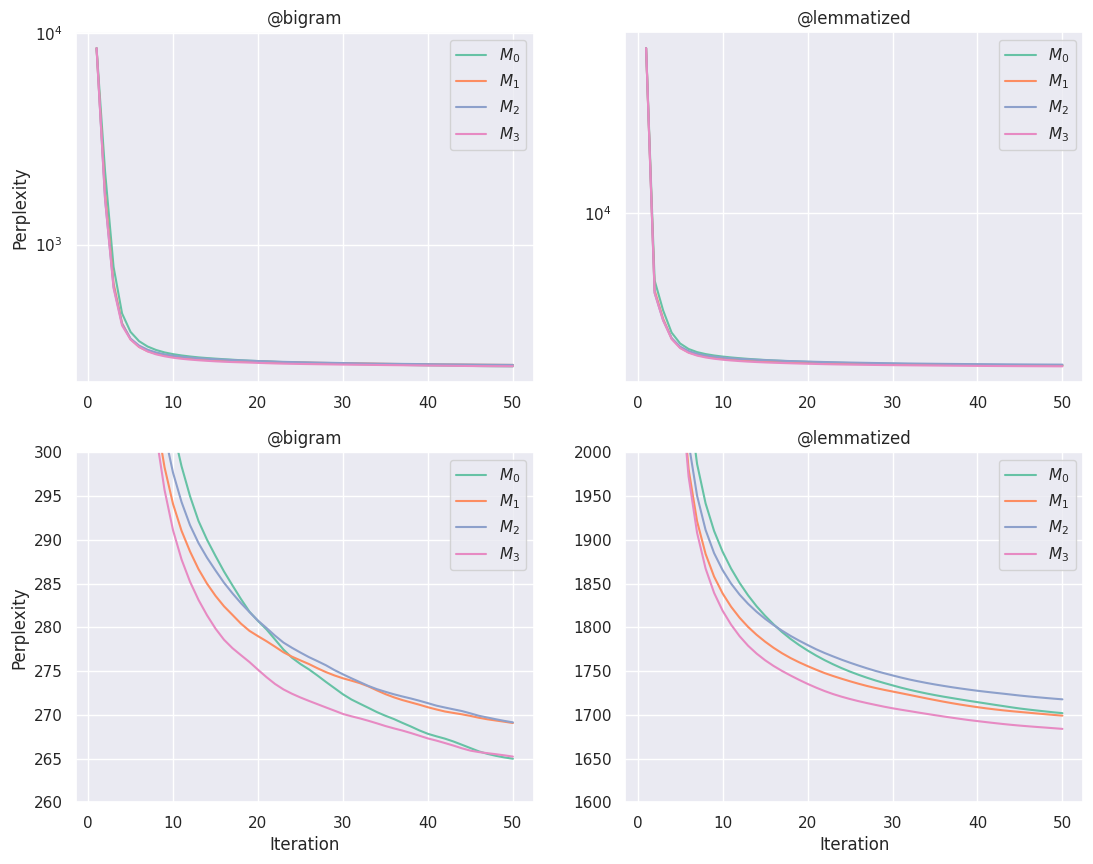

In [30]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(13, 10))
    plt.subplot(2, 2, 1)
    plt.title("@bigram")
    for cur_model, model_name in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"]
    ):
        plt.plot(
            np.arange(1, 51),
            cur_model.score_tracker["PerplexityScore@bigram"].value,
            label=model_name,
        )
    plt.yscale("log")
    plt.legend()
    plt.ylabel("Perplexity")

    plt.subplot(2, 2, 2)
    plt.title("@lemmatized")
    for cur_model, model_name in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"]
    ):
        plt.plot(
            np.arange(1, 51),
            cur_model.score_tracker["PerplexityScore@lemmatized"].value,
            label=model_name,
        )
    plt.yscale("log")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title("@bigram")
    for cur_model, model_name in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"]
    ):
        plt.plot(
            np.arange(1, 51),
            cur_model.score_tracker["PerplexityScore@bigram"].value,
            label=model_name,
        )
    plt.ylim(260, 300)
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Perplexity")

    plt.subplot(2, 2, 4)
    plt.title("@lemmatized")
    for cur_model, model_name in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"]
    ):
        plt.plot(
            np.arange(1, 51),
            cur_model.score_tracker["PerplexityScore@lemmatized"].value,
            label=model_name,
        )
    plt.ylim(1600, 2000)
    plt.legend()
    plt.xlabel("Iteration")

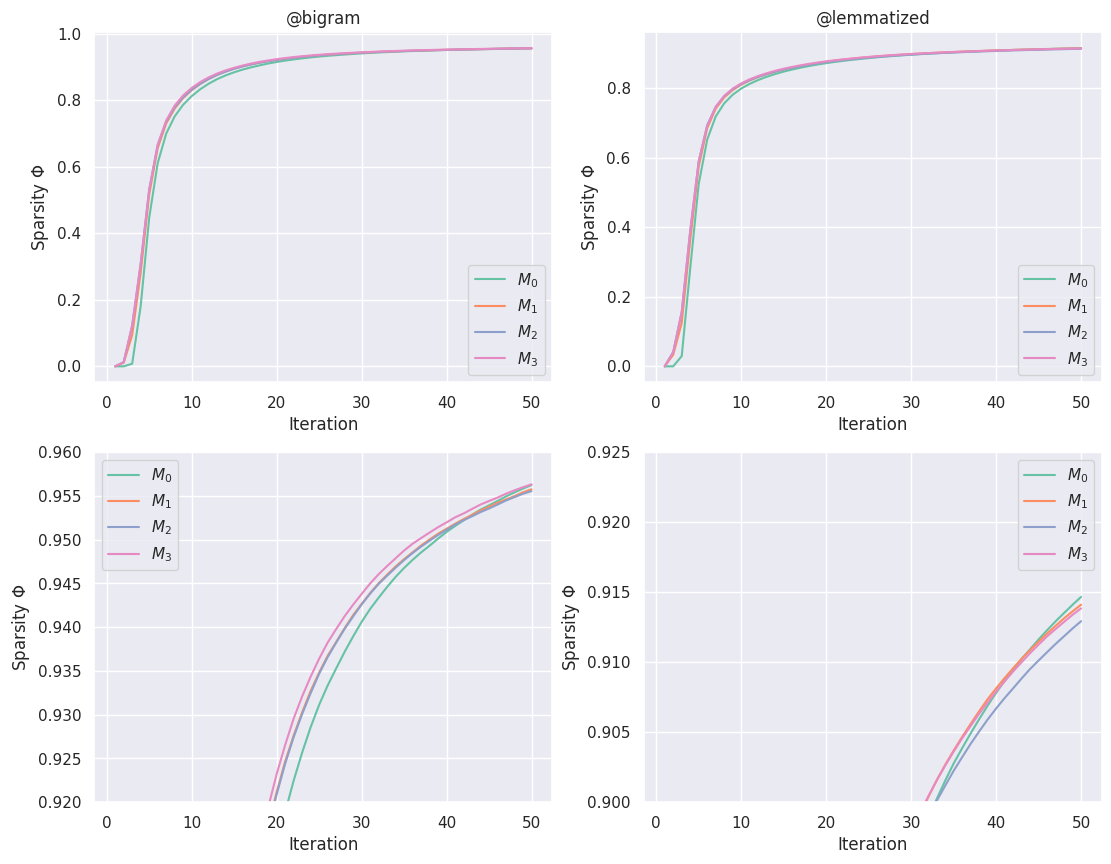

In [31]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(13, 10))
    plt.subplot(2, 2, 1)
    plt.title("@bigram")
    for cur_model, model_name in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"]
    ):
        plt.plot(
            np.arange(1, 51),
            cur_model.score_tracker["SparsityPhiScore@bigram"].value,
            label=model_name,
        )
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

    plt.subplot(2, 2, 2)
    plt.title("@lemmatized")
    for cur_model, model_name in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"]
    ):
        plt.plot(
            np.arange(1, 51),
            cur_model.score_tracker["SparsityPhiScore@lemmatized"].value,
            label=model_name,
        )
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

    plt.subplot(2, 2, 3)
    for cur_model, model_name in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"]
    ):
        plt.plot(
            np.arange(1, 51),
            cur_model.score_tracker["SparsityPhiScore@bigram"].value,
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.92, 0.96)
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

    plt.subplot(2, 2, 4)
    for cur_model, model_name in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"]
    ):
        plt.plot(
            np.arange(1, 51),
            cur_model.score_tracker["SparsityPhiScore@lemmatized"].value,
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.9, 0.925)
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

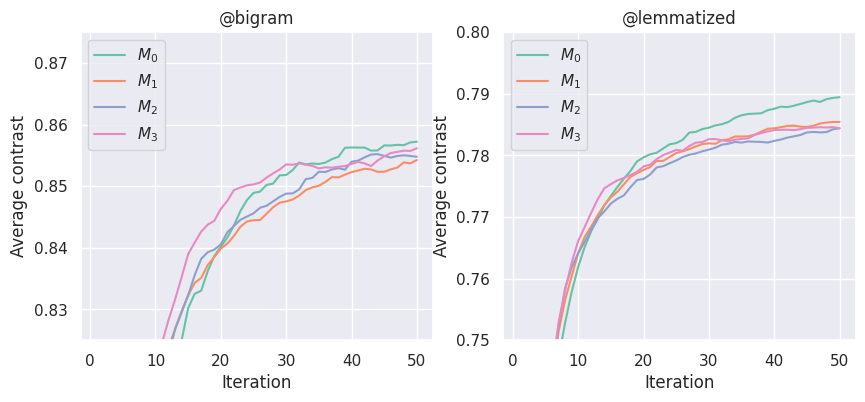

In [32]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("@bigram")
    for cur_model, model_name in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"]
    ):
        plt.plot(
            np.arange(1, 51),
            cur_model.score_tracker["TopicKernel@bigram"].average_contrast,
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.825, 0.875)
    plt.xlabel("Iteration")
    plt.ylabel("Average contrast")

    plt.subplot(1, 2, 2)
    plt.title("@lemmatized")
    for cur_model, model_name in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"]
    ):
        plt.plot(
            np.arange(1, 51),
            cur_model.score_tracker["TopicKernel@lemmatized"].average_contrast,
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.75, 0.8)
    plt.xlabel("Iteration")
    plt.ylabel("Average contrast")